### Distribution of indel frequency

In [1]:
import os 
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
#############################################
def is_Exist_file(path):
    import os
    if os.path.exists(path):
        os.remove(path)


def mkdir(path):
    import os
    path = path.strip()  
    path = path.rstrip("\\")  
    isExists = os.path.exists(path)
    if not isExists:
        os.makedirs(path) 
        print(path + ' 创建成功')
    else:
        print(path + ' 目录已存在') 


def walk(path):
    import os
    input_path_list = []
    if not os.path.exists(path):
        return -1
    for root, dirs, names in os.walk(path):
        for filename in names:
            input_path = os.path.join(root, filename)
            input_path_list.append(input_path)
    return input_path_list

In [3]:
## plot disrplot
def determin_thev(data, lib, barcode_range, reads_range):
    df_ef = data.loc[data['lib_label']=='lib%s'%(lib), :]
    x_dict = {}
    for i in barcode_range:
        for j in reads_range:
            df_ef_temp = df_ef.loc[(df_ef['sgRNA_barcode_n']>=i)&(df_ef['sgRNA_reads_n']>=j),:].reset_index(drop=True)
            x_temp = df_ef_temp['indel_efficiency'].tolist()
            x = np.array(x_temp)
            x_dict['(barcode_n, reads_n)=(%s, %s)'%(i,j)] = x
    return x_dict


def plot_distplot(x_dict, xlabel, savefig_path):
    # 所有gRNA效率密度图 分布图
    import numpy as np
    import math
    from scipy import stats, integrate
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.set(color_codes=True)
    plt.figure(figsize=(6, 4))
    plt.rcParams['lines.linewidth']=0.5
    # 为坐标轴设置名称
    plt.xlabel(xlabel,fontsize=13)
    plt.ylabel("Density", fontsize=13)
    colors = [
             'plum','violet','purple','m','lightseagreen','magenta',
             'slategrey','lightsteelblue','cornflowerblue','royalblue','darkorange','lightgreen',
             'green','r','teal','blue','slateblue','darkslateblue',
             'maroon','blueviolet','indigo','darkorchid','mediumorchid','thistle',
             'orchid','chartreuse','deeppink','hotpink','palevioletred','pink']
    k = 0
    for i in barcode_range:
        for j in reads_range:
            sgRNA_n = len(x_dict['(barcode_n, reads_n)=(%s, %s)'%(i,j)])
            plt.bar([0],[0],label='(barcode_n, reads_n)=(%s, %s)--sgRNA_n=%s'%(i,j,sgRNA_n),fc = colors[k])
            sns.distplot(x_dict['(barcode_n, reads_n)=(%s, %s)'%(i,j)],hist=False,color=colors[k])
            k+=1
    plt.legend(loc='upper left',fontsize=4)
    plt.savefig(savefig_path, dpi=300)
    plt.show()

###  indel efficiency distribution

In [4]:
import os 
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [5]:
# 所有gRNA效率密度图 分布图
############################################################################
def efficiency_distribution(x_dict, cell_line, save_path):
    import numpy as np
    import math
    from scipy import stats, integrate
    import seaborn as sns
    import matplotlib.pyplot as plt
    # 设置默认绘图风格
    plt.style.use("seaborn-white")  
    fig, ax = plt.subplots(1,1, figsize=(6, 3))
    # 为坐标轴设置名称
    plt.xlabel("Efficiency", fontsize=12, weight='bold')
    plt.ylabel("Density", fontsize=12, weight='bold')
    ## 坐标轴不可见
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    colors = ['royalblue','darkorange','lightgreen','teal','palevioletred','pink', 
             'maroon','blueviolet','indigo','darkorchid','mediumorchid','thistle',
             'plum','violet','purple','m','lightseagreen','magenta',
             'orchid','chartreuse','deeppink','hotpink']
    k = 0
    for lib, pdata in x_dict.items():
        plt.bar([0],[0],label='library-%s'%(eval(lib)-1), fc = colors[k])
        sns.distplot(pdata, hist=False, color=colors[k])
        k += 1
    ## xlim
    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.xlim(-0.1, 1.0)
    ## title
    plt.title("The distribution of gRNA activity for %s libraries"%(cell_line), weight='bold')
    plt.legend(loc='upper right', fontsize=9, prop={'weight': 'bold'})
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_efficiency_distribution(cell_line, data, save_dir, 
                                 reads_cutoff, barcode_cutoff, replicate):
    data = data.loc[(data['sgRNA_reads_n']>=reads_cutoff) & (data['sgRNA_barcode_n']>=barcode_cutoff), :]
    x_dict = {}
    for lib_label in data['lib_label'].unique():
        lib = lib_label[-1]
        x_dict[lib] = np.array(data.loc[data['lib_label']==lib_label, :]['edit_efficiency'])
    ## plot
    mkdir(save_dir)
    save_path = save_dir + '/distribution_of_gRNA_activity_%s_%s.%s'%(cell_line, replicate, figsuplix)
    efficiency_distribution(x_dict, cell_line, save_path)
############################################################################

### Reproducibility across cell lines

In [6]:
import os 
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [7]:
## get data for cell line
def get_dataset(data_dir, cell_line, reads_cutoff, barcode_cutoff):
    data_path_S1 = data_dir%(cell_line) + '/%s_S1_ADJ_gRNA_edit_indel_frameshift_efficiency.log'%(cell_line)
    data_path_S2 = data_dir%(cell_line) + '/%s_S2_ADJ_gRNA_edit_indel_frameshift_efficiency.log'%(cell_line)
    ## read data
    data1 = pd.read_csv(data_path_S1, sep='\t')
    data2 = pd.read_csv(data_path_S2, sep='\t')
    print('\n', data1.shape, data2.shape)
    data1 = data1.loc[(data1['sgRNA_reads_n']>=reads_cutoff) & (data1['sgRNA_barcode_n']>=barcode_cutoff), :]
    data2 = data2.loc[(data2['sgRNA_reads_n']>=reads_cutoff) & (data2['sgRNA_barcode_n']>=barcode_cutoff), :]
    data1.reset_index(drop=True, inplace=True)
    data2.reset_index(drop=True, inplace=True)
    print("After filtering (%s, %s), data1.shape:"%(reads_cutoff, barcode_cutoff), data1.shape, "data2.shape:", data2.shape)
    data1 = data1[['sgRNA_name', 'lib_label', 'indel_efficiency']]
    data2 = data2[['sgRNA_name', 'lib_label', 'indel_efficiency']]
    data1.rename(columns={'indel_efficiency': '%s_rep1'%(cell_line)}, inplace=True)
    data2.rename(columns={'indel_efficiency': '%s_rep2'%(cell_line)}, inplace=True)
    return (data1, data2)


## correlation dataset
def correlation_data(data_dir, reads_cutoff, barcode_cutoff):
    ## read data
    data1_k562, data2_k562 = get_dataset(data_dir, 'K562', reads_cutoff, barcode_cutoff)
    data1_jurkat, data2_jurkat = get_dataset(data_dir, 'Jurkat', reads_cutoff, barcode_cutoff)
    ## collect correlation data
    data_dict = {'K562_rep1': data1_k562, 'K562_rep2': data2_k562, 
                 'Jurkat_rep1': data1_jurkat, 'Jurkat_rep2': data2_jurkat, 
                }
    stat_pearson_dict = {}
    stat_spearman_dict = {}
    for label1, data1 in data_dict.items():
        index = []
        for label2, data2 in data_dict.items():
            index.append(label2)
            data = pd.merge(data1, data2, how='inner', on=['sgRNA_name', 'lib_label'])
            data.reset_index(drop=True, inplace=True)
            if label1 == label2:
                pear = data[label1+ '_x'].corr(data[label2 + '_y'], method='pearson')
                spear = data[label1 + '_x'].corr(data[label2 + '_y'], method='spearman')
            else:
                pear = data[label1].corr(data[label2], method='pearson')
                spear = data[label1].corr(data[label2], method='spearman')
            if label1 in stat_pearson_dict:
                stat_pearson_dict[label1].append(pear)
                stat_spearman_dict[label1].append(spear)
            else:
                stat_pearson_dict[label1] = [pear]
                stat_spearman_dict[label1] = [spear]
    ## DataFrame
    stat_pear = pd.DataFrame(stat_pearson_dict)
    stat_spear = pd.DataFrame(stat_spearman_dict)
    stat_pear.index = index
    stat_spear.index = index
    return (stat_pear, stat_spear)
####################################################################

In [8]:
## plor heatmap correlation
def plot_heatmap_correlation(corr_data, corr_label, save_dir):
    ## 绘制 heatmap
    import matplotlib.pyplot as plt
    import seaborn as sns
    #设置右上三角不绘制
    plt.figure(figsize=(6.0, 4.0))

    sns.set_style("white")
    #mask为 和相关系数矩阵xcorr一样大的 全0(False)矩阵
    mask = np.zeros_like(corr_data, dtype=np.bool)
    # 将mask右上三角(列号》=行号)设置为True
    mask[np.triu_indices_from(mask)] = True
    for i in range(mask.shape[0]):
        mask[i, i] = False
    #cmap是设置热图的颜色
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    #绘制热图
    g = sns.heatmap(corr_data, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f', 
                   vmin=0.)
    plt.xticks(rotation=90, weight='bold')
    plt.yticks(rotation=0, weight='bold')

    plt.title("The %s correlation of efficiency among different experiment replicates"%(corr_label), 
              fontsize=12, weight='bold')
    mkdir(save_dir)
    save_path = save_dir + '/%s_on_target_correlation_across_cell_lines-2.pdf'%(corr_label)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
####################################################

### gRNA 编辑效率对核苷酸位置的偏好性

In [9]:
import os 
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [10]:
def is_Exist_file(path):
    import os
    if os.path.exists(path):
        os.remove(path)


def mkdir(path):
    import os
    path = path.strip()  # 去除首位空格
    path = path.rstrip("\\")  # 去除尾部 \ 符号
    isExists = os.path.exists(path)  # 判断路径是否存在
    # 判断结果
    if not isExists:
        os.makedirs(path)  # 如果不存在则创建目录
        print(path + ' 创建成功')
    else:
        print(path + ' 目录已存在')  # 如果目录存在则不创建，并提示目录已存在

In [11]:
## get data for cell line
def get_dataset_2(cell_line, reads_cutoff, barcode_cutoff):
    data_path_S1 = './On-Target/data/remove batch effect/%s/%s_S1_ADJ_gRNA_edit_indel_frameshift_efficiency.log'%(cell_line, cell_line)
    data_path_S2 = './On-Target/data/remove batch effect/%s/%s_S2_ADJ_gRNA_edit_indel_frameshift_efficiency.log'%(cell_line, cell_line)
    ## read data
    data1 = pd.read_csv(data_path_S1, sep='\t')
    data2 = pd.read_csv(data_path_S2, sep='\t')
    print('\n', data1.shape, data2.shape)
    data1 = data1.loc[(data1['sgRNA_reads_n']>=reads_cutoff) & (data1['sgRNA_barcode_n']>=barcode_cutoff), :]
    data2 = data2.loc[(data2['sgRNA_reads_n']>=reads_cutoff) & (data2['sgRNA_barcode_n']>=barcode_cutoff), :]
    # print(data1.columns)
    data1.reset_index(drop=True, inplace=True)
    data2.reset_index(drop=True, inplace=True)
    print("After filtering (%s, %s), data1.shape:"%(reads_cutoff, barcode_cutoff), data1.shape, "data2.shape:", data2.shape)
    data1.rename(columns={'gRNASeq(up20bp+target20bp+pam3bp+down20bp)': 'gRNASeq63bp'}, inplace=True)
    data2.rename(columns={'gRNASeq(up20bp+target20bp+pam3bp+down20bp)': 'gRNASeq63bp'}, inplace=True)
    data1['gRNAUp'] = data1['gRNASeq63bp'].apply(lambda x: x[:20])
    data1['gRNATarget'] = data1['gRNASeq63bp'].apply(lambda x: x[20:40])
    data1['PAM'] = data1['gRNASeq63bp'].apply(lambda x: x[40:43])
    data1['gRNADown'] = data1['gRNASeq63bp'].apply(lambda x: x[43:])
    data2['gRNAUp'] = data2['gRNASeq63bp'].apply(lambda x: x[:20])
    data2['gRNATarget'] = data2['gRNASeq63bp'].apply(lambda x: x[20:40])
    data2['PAM'] = data2['gRNASeq63bp'].apply(lambda x: x[40:43])
    data2['gRNADown'] = data2['gRNASeq63bp'].apply(lambda x: x[43:])
    del data1['gRNASeq63bp']
    del data2['gRNASeq63bp']
    return (data1, data2)

In [12]:
##
def pos_dep_log_odds(df_hig_quart,df_low_quart):
    import math
    A_log_odds = []
    C_log_odds = []
    G_log_odds = []
    T_log_odds = []
    df_hig_quart['sgRNA_seq_PAM'] = df_hig_quart['gRNAUp'] + df_hig_quart['gRNATarget'] + df_hig_quart['PAM'] + df_hig_quart['gRNADown']
    df_low_quart['sgRNA_seq_PAM'] = df_low_quart['gRNAUp'] + df_low_quart['gRNATarget'] + df_low_quart['PAM'] + df_low_quart['gRNADown']
    for i in range(63):
        df_hig_quart['temp_pos_nuc'] = df_hig_quart['sgRNA_seq_PAM'].apply(lambda x: str.upper(x[i]))
        df_low_quart['temp_pos_nuc'] = df_low_quart['sgRNA_seq_PAM'].apply(lambda x: str.upper(x[i]))
        hig_info_dict = dict(df_hig_quart['temp_pos_nuc'].value_counts())
        hig_total_n = len(df_hig_quart) 
        low_info_dict = dict(df_low_quart['temp_pos_nuc'].value_counts())
        low_total_n = len(df_low_quart)
        for k in ['A','T','G','C']:
            if (i != 41) and (i != 42):
                nuc_poss_hig = round(hig_info_dict[k]/hig_total_n,4)
                nuc_poss_low = round(low_info_dict[k]/low_total_n,4)
                log_odds = round(math.log(nuc_poss_hig/nuc_poss_low),4)
                if k == 'A':
                    A_log_odds.append(log_odds)
                elif k == 'T':
                    T_log_odds.append(log_odds)
                elif k == 'C':
                    C_log_odds.append(log_odds)
                elif k == 'G':
                    G_log_odds.append(log_odds)
            else:
                if k == 'A':
                    A_log_odds.append(0)
                elif k == 'T':
                    T_log_odds.append(0)
                elif k == 'C':
                    C_log_odds.append(0)
                elif k == 'G':
                    G_log_odds.append(0)
    return (A_log_odds,C_log_odds,G_log_odds,T_log_odds)


## plot logomaker
def plot_logomaker(crp_df, title, savefig_path):
    import matplotlib.pyplot as plt
    import logomaker
    fig,ax = plt.subplots(1,1,figsize=[17.0,3.0])
    # create Logo object
    crp_logo = logomaker.Logo(crp_df,
                              ax=ax,
                              shade_below=0,
                              fade_below=0,
                              font_name='Arial Rounded MT Bold')
    # style using Logo methods
    # crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.style_xticks(rotation=0, fmt='%d', anchor=0)
    # style using Axes methods
    crp_logo.ax.set_xlabel("The position of nucleotides on target", labelpad=-1, weight='bold')
    crp_logo.ax.set_ylabel("Log-odds score", labelpad=-1, weight='bold')
    crp_logo.ax.set_xlim([-1, 63])
    crp_logo.ax.set_ylim([-3, 3])
    crp_logo.ax.set_yticks([-1,0,1])
    crp_logo.ax.set_yticklabels([-1,0,1])

    # 显示xticks
    name_list = [-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,
                 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,'N','G','G',
                24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43]
    x_new = [0,2,4,6,8,10,11,12,13,14,15,16,17,18,19,
             20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,
             43,44,45,46,48,50,52,54,56,58,60,62]
    x_dict = {}
    for i in range(len(name_list)):
        x_dict[i] = name_list[i]
    x_new_dict = {}
    for i in range(len(name_list)):
        if i in x_new:
            x_new_dict[i] = name_list[i]
        else:
            x_new_dict[i] = ''
    name_new_list = [x_new_dict[i] for i in range(len(name_list))]
    crp_logo.ax.set_xticklabels(name_new_list)

    # # style using Axes methods
    y = -2.2
    y_1 = y-0.3
    # adding axvline
    for i in range(64):
        crp_logo.ax.axvline(i-0.5, color='k', linewidth=1, linestyle=':')
    crp_logo.ax.axhline(y, color='k', linewidth=1)

    # highlight functional regions of ARS1
    crp_logo.highlight_position_range(pmin=20, pmax=39, color='lavenderblush')
    crp_logo.highlight_position_range(pmin=40, pmax=42, color='lightcyan')

    # UP
    crp_logo.ax.plot([-0.5,19.5],[y, y], color='black', linewidth=2, solid_capstyle='butt')
    crp_logo.ax.text(9,y_1,'upstream',fontsize=12)
    # target region
    crp_logo.ax.plot([19.5, 39.5],[y, y], color='red', linewidth=2, solid_capstyle='butt')
    crp_logo.ax.text(29,y_1,'Target',fontsize=12)
    # PAM
    crp_logo.ax.plot([39.5,42.5],[y, y], color='b', linewidth=2, solid_capstyle='butt')
    crp_logo.ax.text(40,y_1,'PAM',fontsize=12)
    # Down
    crp_logo.ax.plot([42.5,62.5], [y, y], color='black', linewidth=2, solid_capstyle='butt')
    crp_logo.ax.text(52,y_1,'downstream', fontsize=12)
    # style and save figure
    plt.title(title, fontsize=12, weight='bold')
#     plt.savefig(savefig_path,dpi=300, bbox_inches='tight')
    plt.show()



## plot logomaker
def main_plot_logomaker(data, cell_line, ycol, title, savefig_path):
    data.rename(columns={ycol: 'eff'}, inplace=True)
    data.sort_values(by='eff', ascending=False, inplace=True)
    data.reset_index(drop=True, inplace=True)
    ##
    n = int(len(data)/4)
    df_hig_quart = data.loc[:n,:]
    df_low_quart = data.loc[(len(data)-n):,:]
    df_low_quart = df_low_quart.reset_index(drop=True)
    result = pos_dep_log_odds(df_hig_quart, df_low_quart)
    A_log_odds, C_log_odds, G_log_odds, T_log_odds = result
    crp_df = pd.DataFrame()
    crp_df['A'] = A_log_odds
    crp_df['C'] = C_log_odds
    crp_df['G'] = G_log_odds
    crp_df['T'] = T_log_odds

    ## plot logomaker
    plot_logomaker(crp_df, title, savefig_path)
#############################################

In [13]:
main_path = "../data"
os.chdir(main_path)

./pdf/on-target/Fig9-sequence determination 创建成功


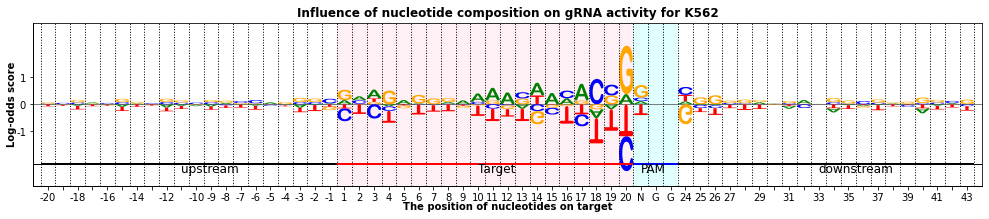

./pdf/on-target/Fig9-sequence determination 目录已存在


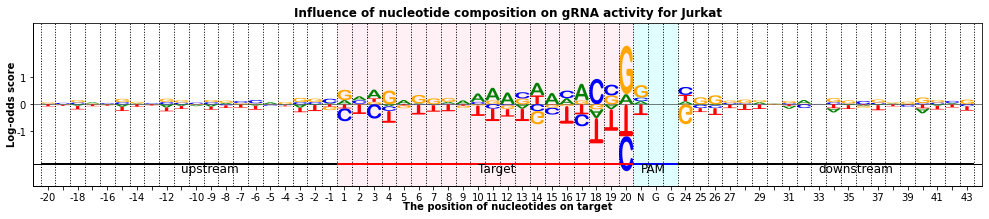

In [14]:
# execute
figsuplix = 'pdf'
for cell_line in ['K562', 'Jurkat']:
    ## read data
    data = pd.read_csv("./On-Target/seq_determination/nucleotide composition/K562_on-target_sequence_data_V2.log", sep='\t')
    ## plot
    ycol = "indel_efficiency"
    title = "Influence of nucleotide composition on gRNA activity for %s"%(cell_line)
    save_dir = './%s/on-target/Fig9-sequence determination'%figsuplix
    mkdir(save_dir)
    title = "Influence of nucleotide composition on gRNA activity for %s"%(cell_line)
    savefig_path = save_dir + '/0LOGO-The position-dependent nucleotides composition_%s_.%s'%(cell_line,   
                                                                                                 figsuplix
                                                                                                 )
    main_plot_logomaker(data, cell_line, ycol, title, savefig_path)